In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sm
import scipy.io
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from shapely.geometry import  LineString
import random as rn
import seaborn as sns

In [3]:
def poly(x,y):
    poly = PolynomialFeatures(degree=4, include_bias=False)
    x=x
    y=y
    poly_features = poly.fit_transform(x.reshape(-1, 1))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y)
    y_predicted = poly_reg_model.predict(poly_features)
    return y_predicted

In [4]:
class Graphs():  
    def __init__(self, m1, m2, m3, C=0, SearchIntersection=False):
        self.C=C
        self.df1 = m1.df
        self.df2 = m2.df
        self.df3 = m3.df

        self.set1 = set(self.df1.columns)
        self.set2 = set(self.df2.columns)
        self.set3 = set(self.df3.columns)
        self.set12 = self.set1 & self.set2
        self.set13 = self.set1 & self.set3
        self.set23 = self.set2 & self.set3
        self.set123 = self.set1 & self.set2 & self.set3
        

        CountDict1 = {}
        for name, values in self.df1.items():
            if len(self.df1[self.df1[name]==1]) != 0:
                CountDict1[name] = (len(self.df1[self.df1[name]==1]))/len(self.df1)
            else:
                CountDict1[name] = 0

        CountDict2 = {}
        for name, values in self.df2.items():
            if len(self.df2[self.df2[name] == 1]) != 0:
                CountDict2[name] = (len(self.df2[self.df2[name] == 1]))/len(self.df2)
            else:
                CountDict1[name] = 0
                
        CountDict3 = {}
        for name, values in self.df3.items():
            if len(self.df3[self.df3[name] == 1]) != 0:
                CountDict3[name] = (len(self.df3[self.df3[name] == 1]))/len(self.df3)
            else:
                CountDict1[name] = 0
        
        
        
        self.Dict123 = {1:CountDict1, 2:CountDict2, 3:CountDict3}

        self.Frame123 = pd.DataFrame(self.Dict123)#.dropna(axis='index')
        self.Frame123 = self.Frame123.loc[list(self.set123)]
        self.Frame123.loc[:,'mean'] = self.Frame123.mean(axis=1)
        
        
        self.new_ids = list(self.Frame123.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.Frame123.sort_values('mean', axis=0, ascending=True)
        self.logFrame = np.log((1-self.SortFrame)/self.SortFrame)
        
        self.SearchIntersection = SearchIntersection
        
        self.x=np.arange(1,len(self.new_ids)+1)
        self.y=(self.logFrame.loc[:,1].to_numpy())
        self.y2=(self.logFrame.loc[:,2].to_numpy())
        self.y3=(self.logFrame.loc[:,3].to_numpy())
        if self.SearchIntersection:    
            line_1 = LineString(np.column_stack((self.x, poly(self.x,self.y))))
            line_2 = LineString(np.column_stack((self.x, poly(self.x,self.y2))))
            line_3 = LineString(np.column_stack((self.x, poly(self.x,self.y3))))
            self.intersection12 = line_1.intersection(line_2)
            self.intersection13 = line_1.intersection(line_3)
            self.intersection32 = line_3.intersection(line_2)
            
    def PrintL(self):
        '''
        Shows how many sites are left and how many intersections by 
        the remaining sites between the periods
        '''
        texts = ['L1', 'L2', 'L3', 'L12', 'L13', 'L23', 'L123']
        sets = [self.set1, self.set2, self.set3, self.set12, self.set13, self.set23, self.set123]
        for i in range(7):
            print(texts[i],'=',str(len(sets[i])))
            


    def sMeasureLine(self, Mean=False, 
                     axis = 'unvalueAxis'):
        """
        makes a graph of beta*s dependence on websites
        """
        
        plt.figure(figsize=(6,3), dpi = 300)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta(t) \\cdot s$')
#         plt.title(f'$f_0={self.f0}, s_0={self.s0}$')
        
        if axis == 'valueAxis':    
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,1].to_numpy()-self.C),
                     'r.-',label='1')
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,2].to_numpy()-self.C),
                     'g.-',label='2')
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,3].to_numpy()-self.C),
                     'k.-',label='3')
            if Mean:
                plt.plot([f"{idx}" for idx in self.new_ids], 
                         (self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',label='mean')
            
        elif axis =='unvalueAxis':
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.plot(self.x, self.yDict[f'y_{n}']-self.C,'.-',
                         label=f't={self.mat["tsecs"][0][n-1]}',color=f'C{n-1}')
            if Mean:
                plt.plot(self.x,(self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',label='mean', color='k')
         
        plt.legend()
 
    
    def PolyS(self):
        plt.figure(figsize=(6,3), dpi = 200)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta(t) \\cdot s_i$')
        for n in range(1,len(self.mat['Data'][0][0][0])+1):
            plt.plot(self.x, self.yDict[f'y_{n}'],'.-',alpha=0.3, 
                     color=f'C{n-1}',label=f't={self.mat["tsecs"][0][n-1]}')
            plt.plot(self.x, poly(self.x,self.yDict[f'y_{n}']), 
                     color=f'C{n-1}')
        plt.legend()    
        if self.SearchIntersection:
            plt.plot(self.x0,self.C,'ok')
        plt.title(f'$f_0={self.f0}, s_0={self.s0}, C={round(self.C,3)}$')

    def sMeasureHist(self, Interpol=False,mean=False):
        """
        A histogram of s values for each site
        """
        if Interpol==False:
            for j in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.figure(figsize=(16,4), dpi=200)
                plt.bar(list(self.logFrame.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None,label='real')
            plt.ylabel(f'$\\beta({self.mat["tsecs"][0][j-1]}) \\cdot s_i$')
            plt.xlabel('nomber of genomic site')
            plt.title(f't={self.mat["tsecs"][0][j-1]},f0={self.f0}')
        else:
            for j in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.figure(figsize=(16,4), dpi=150)
                plt.bar(np.array(self.logFrame.T.columns), 
                        [i for i in (self.table_poly_s).values[j-1]],
                        bottom=None, alpha=0.4, color='green',label='poly')
                plt.bar(list(self.logFrame.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None, alpha=0.4, color='red',label='real')
                plt.legend()
                plt.ylabel(f'$\\beta({self.mat["tsecs"][0][j-1]}) \\cdot s_i$')
                plt.xlabel('nomber of genomic site')
                plt.title(f't={self.mat["tsecs"][0][j-1]},f0={self.f0}, s_0={self.s0}')
        if mean:
            plt.figure(figsize=(16,4), dpi=150)
            plt.bar(list(self.logFrame.T.columns),self.meanPolyBeta,
                    bottom=None, alpha=0.4, color='green',label='poly')
            plt.bar(list(self.logFrame.T.columns),self.meanBeta,
                    bottom=None, alpha=0.4, color='red',label='real')
            plt.legend()
            plt.ylabel('$\\beta_{mean} \\cdot s_i$')
            plt.xlabel('nomber of genomic site')
            plt.title('t={mean}',f'f0={self.f0}, s_0={self.s0}')

In [5]:
def CreateFromData(mat, run, name):
    '''
    Makes a dict of n separate matrix objects, each with its own time period
    '''
    mSimDict = dict()
    for i in range(len(mat[name][0][0][0])):
        mSimDict[i]=pd.DataFrame(mat[name][0][run][0][i],
                         index=range(1,mat[name][0][run][0][i].shape[0]+1),
                         columns=range(1,mat[name][0][run][0][i].shape[1]+1))
    miDict = dict()
    for i in mSimDict:
        miDict[f'm{i+1}'] = Matrix()
        miDict[f'm{i+1}'].df = mSimDict[i] 

    return miDict

In [6]:
class GraphsForSim1():
    '''
    auxiliary class -
    they represent each run of the simulation separately and then we average them.
    '''
    def __init__(self, miDict):
        self.DictN = dict()
        for mi in range(len(miDict)):
            CountDict = dict()
            for i, values in miDict[f'm{mi+1}'].df.items():
                CountDict[i] = miDict[f'm{mi+1}'].df[i].sum()/len(miDict[f'm{mi+1}'].df[i])
            self.DictN[mi+1] = CountDict
        self.FrameN = pd.DataFrame(self.DictN)  

In [7]:
class GraphsForSim2(Graphs):
    '''
    a class that is used when we take a simulation over multiple runs as data 
    '''
    def __init__(self,FileName,f0,s0,C=0,SearchIntersection=True):
        self.C=C
        self.f0=f0
        self.s0=s0
        name='Data'
        self.mat=scipy.io.loadmat(FileName)
        grDict = dict()
        for i in range(len(self.mat[name][0])):
            miDict = CreateFromData(self.mat, i,name)
            grDict[f'grS{i+1}']=GraphsForSim1(miDict)
        DataSum = pd.DataFrame(np.zeros((grDict['grS1'].FrameN.T.shape)),
                               index=range(1,grDict['grS1'].FrameN.shape[1]+1),
                               columns=range(1,grDict['grS1'].FrameN.shape[0]+1)).T
        for i in grDict:
            DataSum = DataSum + grDict[i].FrameN
        self.FrameN=DataSum/len(self.mat[name][0])
        self.FrameN.loc[:,'mean'] = self.FrameN.mean(axis=1)
        self.new_ids = list(self.FrameN.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.FrameN.sort_values('mean', axis=0, ascending=True)
        self.logFrame = -1*np.log(self.SortFrame)
        
        self.real_s = pd.DataFrame(self.mat['s'],index=['s'],
                                   columns=range(1,len(self.mat['s'][0])+1))

        self.SearchIntersection = SearchIntersection
        self.x=np.arange(1,len(self.new_ids)+1)
        self.yDict = dict()
        for n in range(1,len(self.mat['Data'][0][0][0])+1):
            self.yDict[f'y_{n}'] = self.logFrame.loc[:,n].to_numpy()

        if self.SearchIntersection:
            x=np.arange(1,100,0.01)
            self.polyDict = dict()
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                self.polyDict[f'line_{n}']=np.poly1d(np.polyfit(self.x,self.yDict[f'y_{n}'],4))
            absDict=dict()
            ncount=1
            for i in range(1,len(self.mat['Data'][0][0][0])+1):
                for j in range(i+1,len(self.mat['Data'][0][0][0])+1):
                    absDict[f'abs{ncount}']=[]
                    for z in x:
                        absDict[f'abs{ncount}'].append((self.polyDict[f'line_{j}'](z)-self.polyDict[f'line_{i}'](z))**2)
                    ncount+=1
            self.absdf=pd.DataFrame(absDict,index=x)
            self.absdf['sum']=self.absdf.sum(axis=1)
            self.x0=self.absdf[self.absdf['sum']==self.absdf['sum'].min()].index[0]
            self.C=np.mean([self.polyDict[f'line_{n}'](self.x0) for n in range(1,len(self.mat['Data'][0][0][0])+1)])

        self.polymers=[]
        for n in range(1,len(self.mat['Data'][0][0][0])+1):
            self.polymers.append(poly(self.x,self.yDict[f'y_{n}']))
            
        self.table_poly_s = pd.DataFrame(self.polymers,
            columns=self.SortFrame.index, 
            index=range(1,len(self.mat['Data'][0][0][0])+1)).T.sort_index().T-self.C
        self.table_s = self.logFrame.sort_index().T.loc[1:len(self.mat['Data'][0][0][0]),:]-self.C
        self.tsecs=list(self.mat["tsecs"][0])
        
    def beta_s(self,mean=False, onePlot=False):
        xs = list(self.real_s.loc[0])
        self.linear_reg=dict()
        self.linear_regp=dict()
        if onePlot:
            fig, ax = plt.subplots(1, len(self.mat['Data'][0][0][0]), figsize=[9, 3],dpi = 200)
#             plt.figure(dpi = 200,figsize=[9,3])

            for i in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.subplot(1,len(self.mat['Data'][0][0][0]),i)
#                 plt.figure(dpi = 200,figsize=(5,3))

                ysp = self.table_poly_s.loc[i,:].to_numpy()

                ys = self.table_s.loc[i,:].to_numpy()
                self.linear_reg[f'line_{i}']=np.poly1d(np.polyfit(xs,ys,1))
                self.linear_regp[f'line_{i}']=np.poly1d(np.polyfit(xs,ysp,1))
                ax[i-1].scatter(xs,ys,color='g', label='real',alpha=0.6)
                ax[i-1].plot(xs,self.linear_reg[f'line_{i}'](xs),color='g')
                ax[i-1].scatter(xs,ysp,color='r', label='poly',alpha=0.6)
                ax[i-1].plot(xs,self.linear_regp[f'line_{i}'](xs),color='r')
                axes = plt.gca()
                axes.axhline(y=0, color='k',ls=':')  
                axes.axvline(x=0, color='k',ls=':')

                plt.legend()
                plt.title(f'$t={self.mat["tsecs"][0][i-1]}, f_0={self.f0}, s_0={self.s0}$', fontsize=10)
            fig.add_subplot(1,1,1, frame_on=False)
            plt.tick_params(labelcolor="none", bottom=False, left=False)
            plt.ylabel(f'$\\beta(t) \\cdot s_i$')
            plt.xlabel('$s$')
        else:
            for i in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.figure(dpi = 200,figsize=(5,3))

                ysp = self.table_poly_s.loc[i,:].to_numpy()

                ys = self.table_s.loc[i,:].to_numpy()
                self.linear_reg[f'line_{i}']=np.poly1d(np.polyfit(xs,ys,1))
                self.linear_regp[f'line_{i}']=np.poly1d(np.polyfit(xs,ysp,1))
                plt.scatter(xs,ys,color='g', label='real',alpha=0.6)
                plt.plot(xs,self.linear_reg[f'line_{i}'](xs),color='g')
                plt.scatter(xs,ysp,color='r', label='poly',alpha=0.6)
                plt.plot(xs,self.linear_regp[f'line_{i}'](xs),color='r')
                ax = plt.gca()
                ax.axhline(y=0, color='k',ls=':')  
                ax.axvline(x=0, color='k',ls=':')
                plt.xlabel('$s$')
                plt.ylabel(f'$\\beta({self.mat["tsecs"][0][i-1]}) \\cdot s_i$')
                plt.legend()
                plt.title(f'$t={self.mat["tsecs"][0][i-1]}, f_0={self.f0}, s_0={self.s0}$')
        if mean:
            plt.figure(dpi=200,figsize=(5,3))
            ysp = self.meanPolyBeta.to_numpy()
            ys = self.meanBeta.to_numpy()
            self.linear_reg['line_mean']=np.poly1d(np.polyfit(xs,ys,1))
            self.linear_regp['line_mean']=np.poly1d(np.polyfit(xs,ysp,1))
            plt.scatter(xs,ys,color='g', label='real',alpha=0.6)
            plt.plot(xs,self.linear_reg['line_mean'](xs),color='g')
            plt.scatter(xs,ysp,color='r', label='poly',alpha=0.6)
            plt.plot(xs,self.linear_regp['line_mean'](xs),color='r')
            ax = plt.gca()
            ax.axhline(y=0, color='k',ls=':')  
            ax.axvline(x=0, color='k',ls=':')
            plt.xlabel('$s$')
            plt.ylabel('$\\beta_{mean} \\cdot s_i$')
            plt.legend()
        

        
        

        

In [8]:
class GraphsForSim3(GraphsForSim2):
    def __init__(self,FileName,f0,s0,C=0,SearchIntersection=False):
        self.C=C
        self.f0=f0
        self.s0=s0
        name='Data'
        self.mat=scipy.io.loadmat(FileName)
        self.grDict = dict()
        self.miDicts={}
        for i in range(len(self.mat[name][0])):
            miDict = CreateFromData(self.mat, i,name)
            self.miDicts[i]=miDict
            self.grDict[f'grS{i+1}']=GraphsForSim1(miDict)
        DataSum = pd.DataFrame(np.zeros((self.grDict['grS1'].FrameN.T.shape)),
                               index=range(1,self.grDict['grS1'].FrameN.shape[1]+1),
                               columns=range(1,self.grDict['grS1'].FrameN.shape[0]+1)).T
        for i in self.grDict:
            DataSum = DataSum + self.grDict[i].FrameN
        self.FrameN=DataSum/len(self.mat[name][0])
        self.FrameN.loc[:,'mean'] = self.FrameN.mean(axis=1)
        self.new_ids = list(self.FrameN.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.FrameN.sort_values('mean', axis=0, ascending=True)
        self.logFrame = np.log((1-self.SortFrame)/self.SortFrame)
        
        self.real_s = pd.DataFrame(self.mat['s'],index=['s'],
                                   columns=range(1,len(self.mat['s'][0])+1))

        self.SearchIntersection = SearchIntersection
        

        if self.SearchIntersection:
            self.x=np.arange(1,len(self.new_ids)+1)
            self.yDict = dict()
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                self.yDict[f'y_{n}'] = self.logFrame.loc[:,n].to_numpy()
            x=np.arange(1,100,0.01)
            self.polyDict = dict()
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                self.polyDict[f'line_{n}']=np.poly1d(np.polyfit(self.x,self.yDict[f'y_{n}'],4))
            absDict=dict()
            ncount=1
            for i in range(1,len(self.mat['Data'][0][0][0])+1):
                for j in range(i+1,len(self.mat['Data'][0][0][0])+1):
                    absDict[f'abs{ncount}']=[]
                    for z in x:
                        absDict[f'abs{ncount}'].append((self.polyDict[f'line_{j}'](z)-self.polyDict[f'line_{i}'](z))**2)
                    ncount+=1
            self.absdf=pd.DataFrame(absDict,index=x)
            self.absdf['sum']=self.absdf.sum(axis=1)
            self.x0=self.absdf[self.absdf['sum']==self.absdf['sum'].min()].index[0]
            self.C=np.mean([self.polyDict[f'line_{n}'](self.x0) for n in range(1,len(self.mat['Data'][0][0][0])+1)])

            self.polymers=[]
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                self.polymers.append(poly(self.x,self.yDict[f'y_{n}']))

            self.table_poly_s = pd.DataFrame(self.polymers,
                columns=self.SortFrame.index, 
                index=range(1,len(self.mat['Data'][0][0][0])+1)).T.sort_index().T-self.C
            self.table_s = self.logFrame.sort_index().T.loc[1:len(self.mat['Data'][0][0][0]),:]-self.C
        self.tsecs=list(self.mat["tsecs"][0])

In [10]:
def ln_t(gr,period,rec,L=100,M=1/4,f0=0.9,f_1f_fig=False,tlines=False):
    M=round(L*M)
    f=np.log(gr.FrameN.loc[range(1,L+1,period),:])
    s10=gr.real_s[[i for i in range(1,L+1,period)]].copy()
    sort_list=list(s10.sort_values('s',axis=1).columns)
    f=f.loc[sort_list]
    t=range(1,max(gr.tsecs))
    s_t_50=np.log(f0/(1-f0))
    f_t=lambda t,s: np.log(1/(1+np.exp(s*(t-s_t_50/s))))
    if f_1f_fig:
        f_1f=np.log(gr.FrameN.loc[range(1,L+1,period),:]/(1-gr.FrameN.loc[range(1,L+1,period),:]))
        f_1f=f_1f.loc[sort_list]
        plt.figure(dpi=200)
        for i in sort_list:
            plt.plot(gr.tsecs,f_1f.loc[i,1:len(gr.tsecs)],label=f's={round(gr.real_s[i][0],3)}')
        plt.legend()
        plt.title(f'$f_0={f0},r={rec},L={L},M={M}$')
        plt.xlabel('t')
        plt.ylabel('$ln\\frac{f}{1-f}$')
    plt.figure(dpi=200)
    for i in sort_list:
        plt.plot(gr.tsecs,f.loc[i,1:len(gr.tsecs)],label=f's={round(gr.real_s[i][0],3)}')
    if tlines:    
        plt.plot(t,f_t(t,0.05),'.',label='s=0.05',c='C0')
        plt.plot(t,f_t(t,0.1),'.',label='s=0.1',c='C1')
        plt.plot(t,f_t(t,0.15),'.',label='s=0.15',c='C2')
        plt.plot(t,f_t(t,0.2),'.',label='s=0.2',c='C3')
    plt.legend()
    plt.title(f'$f_0={f0},r={rec},L={L},M={M}$',fontsize='x-small')
    plt.xlabel('t')
    plt.ylabel('$ln(f)$');
    if f_1f_fig:
        return f_1f,f
    else:
        return f

In [11]:
def bst(gr,f0,r=0.1,M=2,f1_f=True):
    ss=[-0.2,-0.1,0.1,0.2]
    bs={}
    std_bs={}
    bs1_f={}
    std_bs1_f={}
    for j,s in enumerate(ss,1):
        bs[s]={}
        std_bs[s]={}
        bs1_f[s]={}
        std_bs1_f[s]={}
        for t in range(1,len(gr.tsecs)+1):
            bs1_f[s][t]=np.log(gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t]/
                            (1-gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t])).mean()
            std_bs1_f[s][t]=np.log(gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t]/
                                (1-gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t])).std()
            bs[s][t]=np.log(gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t]).mean()
            std_bs[s][t]=np.log(gr.FrameN.loc[range(j,len(gr.FrameN)+1,4),t]).std()
    bs=pd.DataFrame(bs)
    std_bs=pd.DataFrame(std_bs)
    bs1_f=pd.DataFrame(bs1_f)
    std_bs1_f=pd.DataFrame(std_bs1_f)
    
    t=range(max(gr.tsecs)+1)
    s_t_50=np.log(f0/(1-f0))
    f_t=lambda t,s: np.log(1/(1+np.exp(s*(t-s_t_50/s))))
    for j,s in enumerate(ss):
#         plt.plot(gr.tsecs,bs[s],color=f'C{j}',label=f's={s}')
        if f1_f:
            plt.errorbar(gr.tsecs,bs1_f[s],std_bs1_f[s],fmt='.',color=f'C{j}',label=f's={s}')
        else:
            plt.errorbar(gr.tsecs,bs[s],std_bs[s],fmt='.',color=f'C{j}',label=f's={s}')
#         plt.plot(t,f_t(t,s),c=f'C{j}')
    plt.legend()
    plt.title(f'$f_0={f0}, L={len(gr.FrameN)}, M={M}, r={r}$')
    plt.xlabel('t')
    plt.ylabel('$\\beta \\cdot s$')
    return bs, std_bs, bs1_f, std_bs1_f

    

In [12]:
def ln_t6(grlist,period,rec,M=1/4,f0=0.9,f_1f_fig=False,tlines=False):
#     M=round(L*M)
    flist=[]
    s10list=[]
    sort_listes=[]
    for num,gr in enumerate(grlist):
        flist.append(np.log(gr.FrameN.loc[range(1,len(gr.real_s)+1,period),:]))
        s10list.append(gr.real_s[[i for i in range(1,len(gr.real_s)+1,period)]].copy())
        sort_listes.append(list(s10list[num].sort_values('s',axis=1).columns))
        flist[num]=flist[num].loc[sort_listes[num]]
    t=range(1,max(grlist[0].tsecs))
    s_t_50=np.log(f0/(1-f0))
    f_t=lambda t,s: np.log(1/(1+np.exp(s*(t-s_t_50/s))))
    plt.figure(figsize=(9,10),dpi=200)
    count=0
    for j in range(3):
        for k in range(2):
            plt.subplot(3,2,count+1)
            for i in sort_listes[count]:
                plt.plot(grlist[count].tsecs,flist[count].loc[i,1:len(grlist[count].tsecs)],
                             label=f's={round(grlist[count].real_s[i][0],3)}')
            if tlines:    
                plt.plot(t,f_t(t,0.05),'.',label='s=0.05',c='C0')
                plt.plot(t,f_t(t,0.1),'.',label='s=0.1',c='C1')
                plt.plot(t,f_t(t,0.15),'.',label='s=0.15',c='C2')
                plt.plot(t,f_t(t,0.2),'.',label='s=0.2',c='C3')
            count=count+1
#     fig.suptitle(f'$f_0={f0},r={rec},L={L},M={M}$',fontsize='x-small')
#     plt.xlabel('t')
#     plt.ylabel('$ln(f)$');
#     if f_1f_fig:
#         return f_1f,f
#     else:
#         return f

In [14]:
def s_measurment(Data):
    ts = scipy.io.loadmat(Data)
    L=40
    numseqs = len(ts['Data'][0])*1000
    tsecs = ts['tsecs'][0]
    ofrst=np.array(ts['Data'][0][0][0][0])
    for r in range(1,len(ts['Data'][0])):
        ofrst=np.append(ofrst,ts['Data'][0][r][0][0])
    odf_1=pd.DataFrame(np.reshape(ofrst,(numseqs,L)))
    oscnd=np.array(ts['Data'][0][0][0][1])
    for r in range(1,len(ts['Data'][0])):
        oscnd=np.append(oscnd,ts['Data'][0][r][0][1])
    odf_2=pd.DataFrame(np.reshape(oscnd,(numseqs,L)))
    othrd=np.array(ts['Data'][0][0][0][2])
    for r in range(1,len(ts['Data'][0])):
        othrd=np.append(othrd,ts['Data'][0][r][0][2])
    odf_3=pd.DataFrame(np.reshape(othrd,(numseqs,L)))

    
    obs1 = np.log((1-(odf_1.sum()/numseqs))/(odf_1.sum()/numseqs)).sort_values(ascending=False).values
    obs2 = np.log((1-(odf_2.sum()/numseqs))/(odf_2.sum()/numseqs)).sort_values(ascending=False).values
    obs3 = np.log((1-(odf_3.sum()/numseqs))/(odf_3.sum()/numseqs)).sort_values(ascending=False).values
#     obs4 = np.log((1-(odf_4.sum()/numseqs))/(odf_4.sum()/numseqs)).sort_values(ascending=False).values
    plt.plot(range(L),obs1,label=f't={tsecs[0]}')
    plt.plot(range(L),obs2,label=f't={tsecs[1]}')
    plt.plot(range(L),obs3,label=f't={tsecs[2]}')
#     plt.plot(range(L),obs4,label=f't={tsecs[3]}')
    plt.legend()
    plt.grid()
    plt.xlabel('$m_i$')
    plt.ylabel('$\\beta(t) \\cdot s_i$')

    plt.title('$f_0=0$')

    yDict = {'y_1':obs1,
             'y_2':obs2,
             'y_3':obs3}
#              'y_4':obs4}
    x=np.arange(1,L,0.01)
    mi = range(L)
    polyDict = dict()
    for n in range(1,4):
        polyDict[f'line_{n}']=np.poly1d(np.polyfit(mi,yDict[f'y_{n}'],4))
    absDict=dict()
    ncount=1
    for i in range(1,4):
        for j in range(i+1,4):
            absDict[f'abs{ncount}']=[]
            for z in x:
                absDict[f'abs{ncount}'].append((polyDict[f'line_{j}'](z)-polyDict[f'line_{i}'](z))**2)
            ncount+=1
    absdf=pd.DataFrame(absDict,index=x)
    absdf['sum']=absdf.sum(axis=1)
    x0=absdf[absdf['sum']==absdf['sum'].min()].index[0]
    C=np.mean([polyDict[f'line_{n}'](x0) for n in range(1,4)])
    print(f'C={C}')

In [15]:
def f_measurment(Data):
    ts = scipy.io.loadmat(Data)
    L=40
    numseqs = len(ts['Data'][0])*1000
    tsecs = ts['tsecs'][0]
    ofrst=np.array(ts['Data'][0][0][0][0])
    for r in range(1,len(ts['Data'][0])):
        ofrst=np.append(ofrst,ts['Data'][0][r][0][0])
    odf_1=pd.DataFrame(np.reshape(ofrst,(numseqs,L)))
    oscnd=np.array(ts['Data'][0][0][0][1])
    for r in range(1,len(ts['Data'][0])):
        oscnd=np.append(oscnd,ts['Data'][0][r][0][1])
    odf_2=pd.DataFrame(np.reshape(oscnd,(numseqs,L)))
    othrd=np.array(ts['Data'][0][0][0][2])
    for r in range(1,len(ts['Data'][0])):
        othrd=np.append(othrd,ts['Data'][0][r][0][2])
    odf_3=pd.DataFrame(np.reshape(othrd,(numseqs,L)))
    return odf_1, odf_2, odf_3, numseqs

In [24]:
def polysearch(tribet,deg=4):
    x=np.arange(1,L,0.01)
    polyd = {}
    for i in range(3):
        polyd[i] = np.poly1d(np.polyfit(range(1,L+1),tribet.iloc[:,i],deg))
    absDict=dict()
    ncount=0
    for i in range(3):
        for j in range(i,3):
            absDict[ncount]=[]
            for z in x:
                absDict[ncount].append((polyd[j](z)-polyd[i](z))**2)
            ncount+=1
    absdf=pd.DataFrame(absDict,index=x)
    absdf['sum']=absdf.sum(axis=1)
    x0=absdf[absdf['sum']==absdf['sum'].min()].index[0]
    C=np.mean([polyd[n](x0) for n in range(3)])
    return polyd,x0,C

In [46]:
heat_list = dict()
C_list = {}
# cntr=1
for name in ['r0M0run50L400']:#names:
    what = GraphsForSim3(name,0.5,0.1,SearchIntersection=False)
    fN = what.FrameN.dropna().copy()
    fN.sort_values('mean',ascending=False,inplace=True)
    L = len(fN)
#     print(L)
    cl = what.tsecs.copy()
    cl.append('mean')
    fN.columns = cl
    fln = -np.log((fN))
    fln.index = range(1,L+1)
    polys,x0,C = polysearch(fln)
    fln_real = fln.iloc[:,:3].copy()
    real = what.real_s.loc['s'].copy()
    real.sort_values(inplace=True)
    real.index = range(1,L+1)
#     print(real)
    fln_real.loc[:,'real_s'] = real 
    heat_list[name] = np.mean(list(fln_real.corr().iloc[3,:3]))

#     cntr=cntr+1
#     print(cntr)

Text(0, 0.5, 'Scaled estimate of selection coefficient')

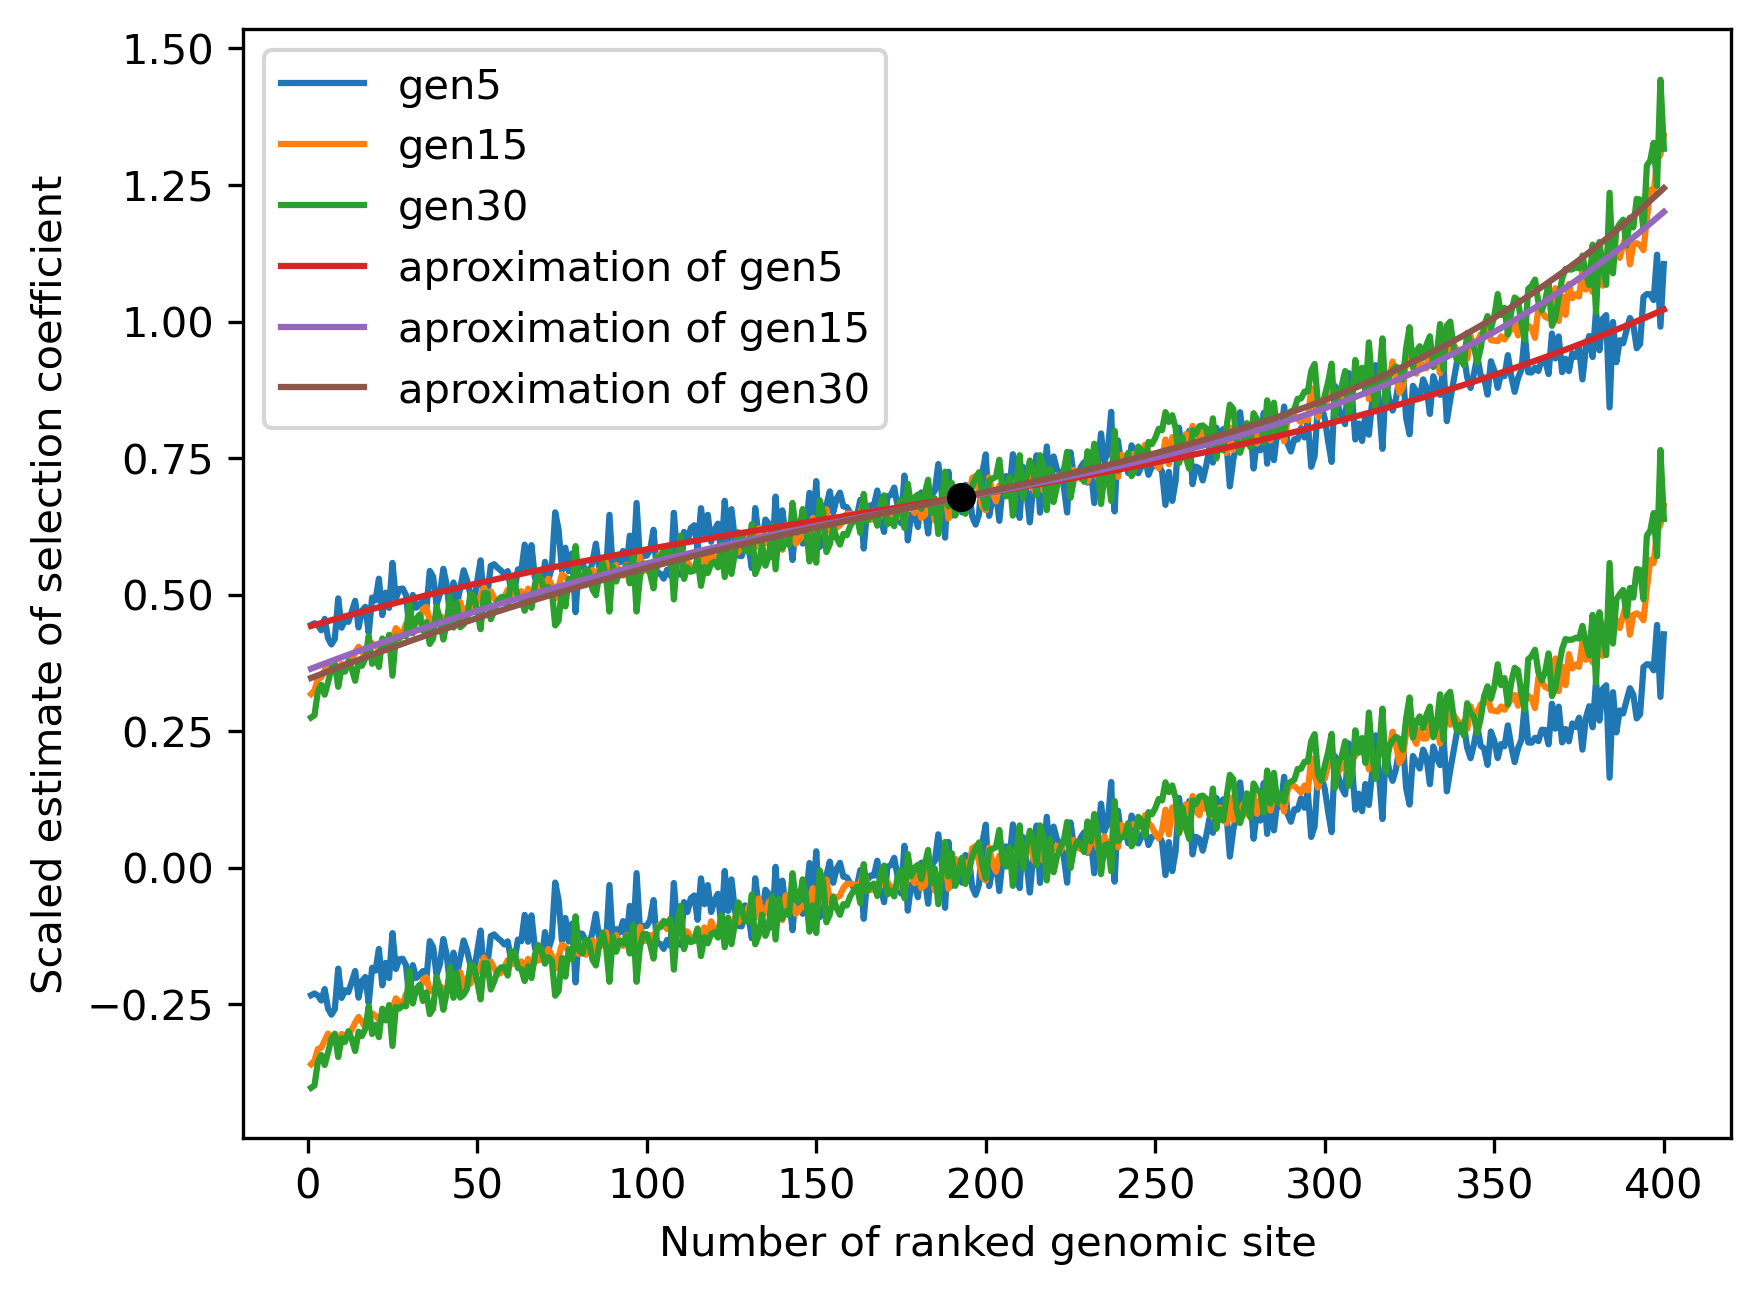

In [47]:
fn = fln.copy()
fn.index = range(1,401)
fn.columns = [0,1,2,'mean']
# polys[0](range(1,401))
line = np.poly1d(np.polyfit(np.linspace(-0.1,0.1,400),fln_real.iloc[:,0],1))
plt.figure(dpi=300)
# plt.plot(x0,0,'ok',label='the intersection point...')
for i in range(3):
    plt.plot(range(1,401),fn[i],color=f'C{i}',label=f'gen{what.tsecs[i]}')
    plt.plot(range(1,401),fn[i]-C,color=f'C{i}')
for i in range(3):
    plt.plot(range(1,401),polys[i](range(1,401)),color=f'C{i+3}',label=f'aproximation of gen{what.tsecs[i]}')
plt.plot(x0,C,'ok')
# plt.grid()
plt.legend()
plt.xlabel('Number of ranked genomic site')
plt.ylabel('Scaled estimate of selection coefficient')#'$\\log \\left( \\frac{f_i}{1-f_i} \\right)$')


# plt.scatter(fln_real['real_s'],fln_real[5]-C)
# plt.plot(np.linspace(-0.1,0.1,10),line(np.linspace(-0.1,0.1,10))-C,'r')
# plt.grid()
# plt.xlabel('simulated s')
# plt.ylabel('measured $\\beta$s')

Text(0, 0.5, 'Estimated selection coefficient, $\\beta s$')

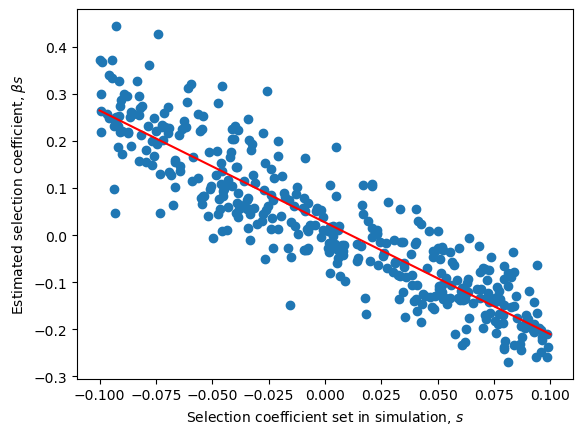

In [78]:
fn = -np.log(fN)
fn.sort_index(inplace=True)
plt.scatter(what.real_s,fn.loc[:,5]-C)
plt.plot(np.linspace(-0.1,0.1,400),np.poly1d(np.polyfit(what.real_s.loc['s'],fn.loc[:,5],1))(np.linspace(-0.1,0.1,400))-C,'r')
plt.xlabel('Selection coefficient set in simulation, $s$')
plt.ylabel('Estimated selection coefficient, $\\beta s$')

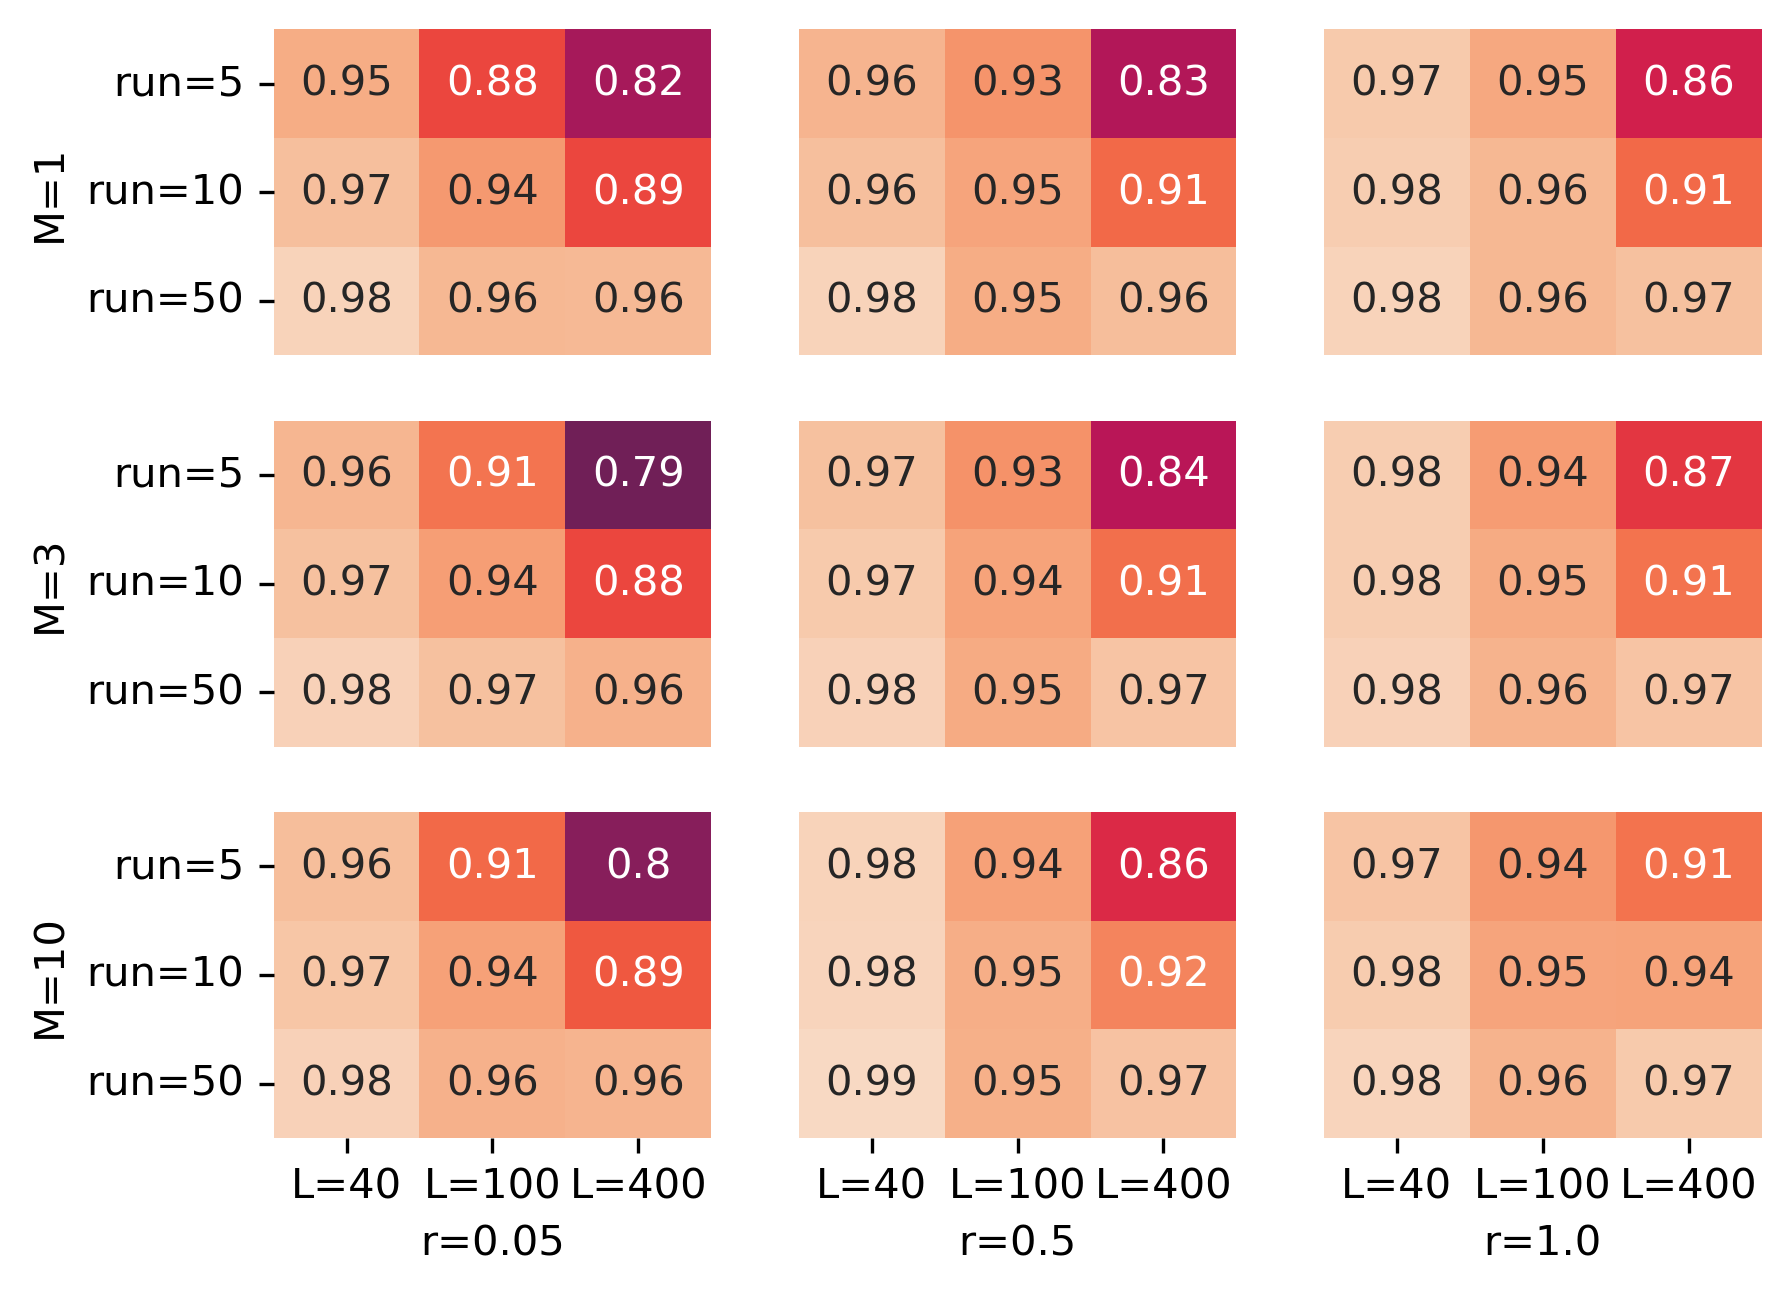

In [79]:
j = 1
plt.figure(dpi=300)
for M in [1,3,10]:
    for r in [5,50,100]:
        ax = plt.subplot(3,3,j)
        if j not in [1,4,7]:
            if j not in [7,8,9]:
                sns.heatmap(-1*monstr[M][r],annot= True,vmax=1,vmin=0.7,
                            cbar=False,yticklabels=False,xticklabels=False)
            else:
                sns.heatmap(-1*monstr[M][r],annot= True,vmax=1,vmin=0.7,
                            cbar=False,yticklabels=False,xticklabels=True)
                plt.xlabel(f'r={r/100}')
        else:
            if j not in [7,8,9]:
                sns.heatmap(-1*monstr[M][r],annot= True,vmax=1,vmin=0.7,
                            cbar=False,yticklabels=True,xticklabels=False)
                plt.ylabel(f'M={M}')
            else:
                sns.heatmap(-1*monstr[M][r],annot= True,vmax=1,vmin=0.7,
                            cbar=False,yticklabels=True,xticklabels=True)
                plt.ylabel(f'M={M}')
                plt.xlabel(f'r={r/100}')
#         ax.set_title('$\\beta \\cdot s = \\ln{f}$')
        j+=1
